# Analyze properties of the interface of the propagating front of OsxGFP positive cells
## (1) Interface dynamics

<b>Version control</b><br>

Method 1 (method 2 for static images): overhang control. Use thresholded binary image, take largest contiguous region.
Method 2: Use phi_X method from Podewitz et al. (2016) to analyze moment equations.    

In [5]:
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pandas import DataFrame
from numpy import fft
import os
cwd = os.getcwd(); print("Working dir: " + cwd)

video = 4; video_idx = video-1; # python index
dates_all = ["190305", "190314", "200120", "170902"];
date = dates_all[video_idx];
folder_data = "/Users/dang/Documents/TablerLab/Data_Live_Imaging/{} Live Imaging/".format(date);
print("Save data in: " + folder_data)
folder_figures = os.path.split(cwd)[0] + "/Figures/Live_Imaging_{}/1c_interface_dynamics_method2/".format(date); 
print("Save plots in: " + folder_figures)

Working dir: /Users/dang/Documents/TablerLab/Code
Save data in: /Users/dang/Documents/TablerLab/Data_Live_Imaging/170902 Live Imaging/
Save plots in: /Users/dang/Documents/TablerLab/Figures/Live_Imaging_170902/1c_interface_dynamics_method2/


In [6]:
# --- Image settings ---
# Total image size in pixels
#size_px = np.array([3782, 2882]); # 190305
#size_px = np.array([5612, 2850]); # 190314/190315 after pruning
# To be precise, 190314: [5612, 2871] and 190315: [5606, 2880] 
# size_px = np.array([4734, 3925]); # 200120
size_px_all = np.array([[3782, 2882], [5612, 2850], [4734, 3925], [4643, 2886]]);

# Number of pixels per micron
#pix_per_micron = 4.400; # 190305
#pix_per_micron = 5.1040; # 190314
#pix_per_micron = 5.1040; # 200120
pix_per_micron_all = [4.400, 5.1040, 5.1040, 4.4034];

# Total size of image in microns
#size = np.array([859.55, 655]); # 190305
#size = np.array([1099.53, 562.5]); # 190314
#size = np.array([1098.35, 564.26]); # 190315
#size = np.array([927.51, 769.01]); # 200120

# Default image label
#im_label = "190305_MaxProjected_Stitched_dataset(0-12hr)_YD";
#im_label = "MaxProjected_Stitched_Blurred_190305_ML1_OsxGFP_Explant_Video_1(0-12hr)_YD";
#im_label = "MaxProjected_Stitched_190314_ML1_OsxGFP_Explant_Video_1_(0-16hr)";
#im_label = "MaxProjected_Stitched_200120_Live_Imaging_OsxGFP_E1375_12_hours";
im_label_all = ["190305_MaxProjected_Stitched_dataset(0-12hr)_YD", 
                "MaxProjected_Stitched_190314_ML1_OsxGFP_Explant_Video_1_(0-16hr)",
                "MaxProjected_Stitched_200120_Live_Imaging_OsxGFP_E1375_12_hours",
               "MAX_BLUR_20200414AQR_osx_E13.5_020917.lif - TileScan_003_Merging"];

# set scales
im_label = im_label_all[video_idx];
pix_per_micron = pix_per_micron_all[video_idx];
size_px = size_px_all[video_idx];
Lx = size_px[0];
Ly = size_px[1];

## Extract interface profiles
Use method 2 (with overhang correction)

### Load data, extract interfaces
16-bit images: intensity values in range 0-65535. Lower thresholds for cutting off very dark regions.
Process data using other notebook. Load processed data here.

In [11]:
# Load interface data
load_folder = folder_data + "/Interface_data/"; 
fname_in = load_folder + im_label + "_interfaces_data_processed" + ".csv";

interfaces_all_df = pd.read_csv(fname_in, index_col=0)
Ly = interfaces_all_df.shape[1]; 

# convert to np array
interfaces_all_0 = np.array(interfaces_all_df); # unprocessed interface data
t_max = interfaces_all_0.shape[0]; # manually input number of time points

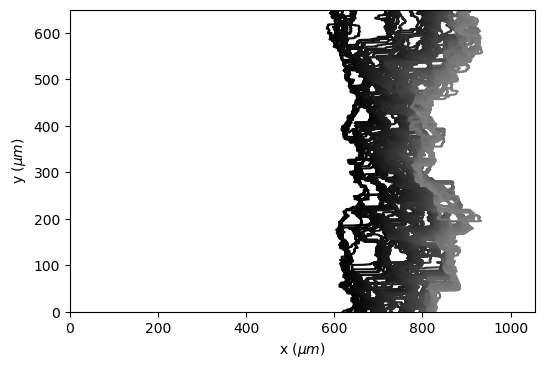

In [12]:
# Check loaded data by plotting interfaces
y_vals = np.arange(Ly);
# Cut out parts of interface for post-processing
lower = 0;
upper = -1; #-150;

h = plt.figure(dpi = 100);
for idx in np.arange(t_max):
    #plt.plot(interfaces_all_0[idx, lower:upper], y_vals[lower:upper], color=str(0.5*idx/t_max)); # in pixels
    plt.plot(interfaces_all_0[idx, lower:upper]/pix_per_micron, y_vals[lower:upper]/pix_per_micron, color=str(0.5*idx/t_max)); # in microns
plt.xlabel('x ($\mu m$)')
plt.ylabel('y ($\mu m$)')
plt.xlim(0, Lx/pix_per_micron)
plt.ylim(0, Ly/pix_per_micron)

plt.show()

In [13]:
# Optional: save processed interfaces
interfaces_all = interfaces_all_0[:, lower:upper];

# Save processed interface
fname_out = load_folder + im_label + "_interfaces_data_processed_lower_{}_upper_{}.csv".format(lower, upper);
interfaces_all_df = pd.DataFrame(interfaces_all)
interfaces_all_df.to_csv(fname_out);

## Interface dynamics (first two moments)
We now determine how the interface height and width evolve over time. <br>

<u>Fisher waves</u><br>
Recall that the Fisher–KPP equation is <br>
    $\hspace{1cm} \partial_t u = D \partial_{xx} u + f(u), \hspace{1cm} f(u) = k u (1-u) $ <br>
For a Fisher wave, the interface grows linearly with time, $\langle h(t) \rangle = v t$. The deterministic model predicts $v = 2 \sqrt{D f'(0)} = 2 \sqrt{D k}$. The stochastic model based on $A \leftrightarrow A + A$ predicts $v = Dk$ in $d=1$ (Moro, PRL 2001). <br>

For the width, different scaling relations for before the saturating regime have been obtained (recall $w(t) \sim t^{\beta}$). Riordan et al. (PRL, 1995) do numerically study the stochastic process on a 2D grid and obtain diffusive scaling, i.e. $\beta=1/2$. Moro (PRL, 2001) shows that with a different interface definition, $\beta = 0.27 \pm 0.01$. 

<u>Other interface growth models</u> <br>
Tumor growth: linear expansion (Bru et al., PRL 1998 & BPJ 2003), also confirmed in CA model simulations by Block et al., 2007.
Monolayer Vero cell colony (Huergo et al., 2010): linear expansion of colony height. $\beta = 0.33$ for large colonies, but $\beta$ depends on system size $l$. 


### Method 2: Probability density method (Podewitz et al., 2016)
Take $\langle h(t) \rangle = \int_{0}^{L_x} \varphi_X(x, t)\ dx$, where $\varphi_X(x, t)$ is the density of ON cells projected onto the x-axis. See Podewitz et al. (2016) and Riordan et al. (PRL, 1995). 

#### (1) Mean interface height dynamics

#### If first time run: compute phi_X and widths for all images
First check for a single image.

Height = 619.6895166782072
Width = 56.36596332685731


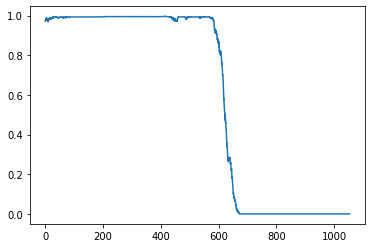

In [14]:
# --- Do for a single image --- 
# ---> Determine whether image needs reversal! Should be phi=1 left, phi=0 right

# Load (raw) image
t = 0;
filepath = folder_data + "/Processed_TXT_data_interface/";
filename_in = "MaxProjected_Stitched_dataset(0-12hr)_YD_processed_interface_t" + str(t) + ".txt";
fullname_in = filepath + filename_in;
data_image = pd.read_csv(fullname_in, header = None, delimiter='\t');
data_image[data_image == 255] = 1; # convert to 0/1

# Reverse x-axis?
reverse = 0;

# Calc phi_X
phi_X = np.mean(data_image, axis=0); # data_image from before
if reverse:
    phi_X = np.flip(phi_X);
    
# Calculate interface position
h = np.sum(phi_X)/pix_per_micron;
print("Height = " + str(h))

# Calculate width
h2 = 2*np.sum( np.arange(len(phi_X))*phi_X )/(pix_per_micron**2); # height in pixels
width = np.sqrt(h2 - h**2);
print("Width = " + str(width))

# Plot phi(X)
plt.figure();
plt.plot( np.arange(len(phi_X))/pix_per_micron , phi_X);
plt.show();

In [15]:
# Do for all images
load_folder = folder_data + "Processed_TXT_data_interface/";
reverse = 0; # <-- important to set!

heights_all = np.zeros(t_max);
widths_all = np.zeros(t_max); 
phi_X_all = np.zeros([t_max, Lx])*np.nan;

for idx in np.arange(t_max):
    t = idx;
    print(t);
    
    # load image
    filename_in = "MaxProjected_Stitched_dataset(0-12hr)_YD_processed_interface_t" + str(t) + ".txt";
    fullname_in = load_folder + filename_in;
    data_image = pd.read_csv(fullname_in, header = None, delimiter='\t');
    data_image[data_image == 255] = 1; # convert to 0/1    
    
    # Calculate phi(X)
    phi_X = np.mean(data_image, axis=0);
    if reverse:  # Important: flip X axis!
        phi_X = np.flip(phi_X);
        
    # Calculate interface position
    h = np.sum(phi_X)/pix_per_micron;

    # Calculate width
    h2 = 2*np.sum( np.arange(len(phi_X))*phi_X )/(pix_per_micron**2); # height in pixels
    width = np.sqrt(h2 - h**2);
    
    # Store data
    phi_X_all[idx, :len(phi_X)] = phi_X;
    heights_all[idx] = h;
    widths_all[idx] = width;

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [17]:
# Export data
# (1) phi_X
xlabels = ['t='+str(i) for i in np.arange(t_max)];
data_phi_to_export_df = pd.DataFrame(phi_X_all, index = xlabels);
filename = folder_data + im_label + "_interface_phi_X" + ".csv";
data_phi_to_export_df.to_csv(filename);

# (2) heights and widths
data_to_export = np.array([heights_all, widths_all]).T;
data_to_export_df = pd.DataFrame(data_to_export, columns=['height', 'width']);
filename = folder_data + im_label + "_interface_h_w_method_2" + ".csv";
data_to_export_df.to_csv(filename)

#### If already run: load data

In [10]:
# Load phi_X
filename = folder_data + im_label + "interface_phi_X" + ".csv";
phi_X_all = pd.read_csv(filename, index_col=0);

# Load heights and weights
filename = load_folder + im_label + "interface_h_w_method_2" + ".csv";
heights_all = pd.read_csv(filename, index_col=0)["height"];
widths_all = pd.read_csv(filename, index_col=0)["width"];

#### Plot results

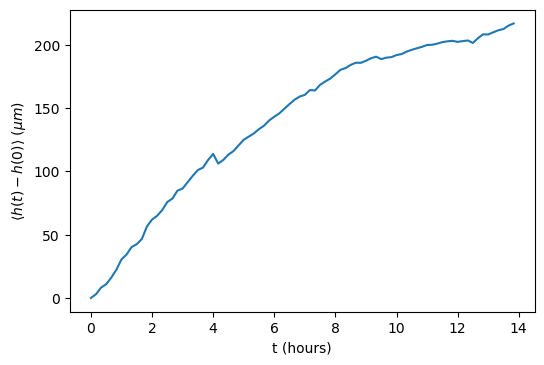

In [18]:
# Plot result
t_all = np.arange(t_max)/6; 
heights_all_norm = heights_all - heights_all[0]; # normalize by initial position

h = plt.figure(dpi = 100);
#plt.plot(t_all, heights_all_1, label='(1) $L^{-1} \int_{0}^{L_y} h(y,t) dy$')
plt.plot(t_all, heights_all_norm, label='(2) $\int_{0}^{L_x} x (- \partial_X \phi_X(x, t)) dx$')
plt.xlabel('t (hours)')
plt.ylabel('$\\langle h(t) - h(0) \\rangle$ ($\mu m$)')
#plt.title('Compare methods 1 and 2')
#plt.legend()

# Plot power laws
# t_sel = np.arange(2, 16);
# exp = 0.06;
# c = 550;
# plt.plot(t_sel, c*(t_sel**exp), '--', label='power='+str(exp))

# Save image
fname_out = folder_figures + im_label + "interface_height_dynamics";
label = '_method_2';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()

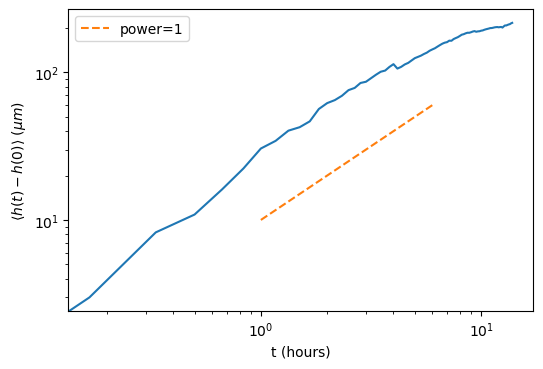

In [19]:
# Plot on log-log scale
# Plot result
t_all = np.arange(t_max)/6; 

plt.figure(dpi = 100);
#plt.plot(t_all, heights_all_1, label='(1) $L^{-1} \int_{0}^{L_y} h(y,t) dy$')
plt.plot(t_all, heights_all_norm); #, label='(2) $\int_{0}^{L_x} x (- \partial_X \phi_X(x, t)) dx$')

# Plot power laws
t_sel = np.array([1, 6]);
exp = 1;
c = 10;
plt.plot(t_sel, c*(t_sel**exp), '--', label='power='+str(exp))
# t_sel2 = np.array([5, 16]);
# exp2 = 0.25;
# c2 = 75;
# plt.plot(t_sel2, c2*(t_sel**exp2), '--', label='power='+str(exp2))

plt.xlabel('t (hours)')
plt.ylabel('$\\langle h(t) - h(0) \\rangle$ ($\mu m$)')
plt.xscale('log')
plt.yscale('log')
#plt.title('Compare methods 1 and 2')
plt.legend()

# Save image
fname_out = folder_figures + im_label + "interface_height_dynamics";
label = '_method_2_log_log';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()

#### (2) Width dynamics
Now take the second moment to be $\langle h(t)^2 \rangle = 2 \int_{0}^{L_x} x\ \phi_X(x, t)\ dx$, where $\phi_X(x, t)$ is the density of ON cells projected onto the x-axis. See Podewitz et al. (2016).

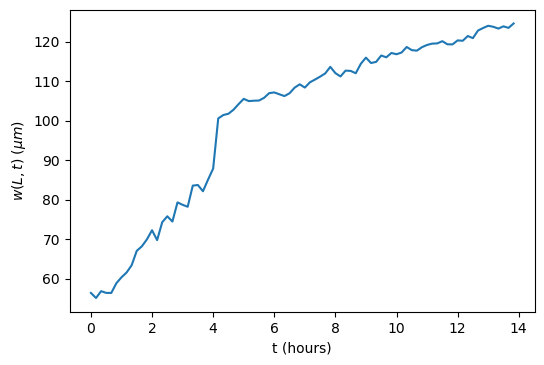

In [20]:
# Plot result and compare
t_all = np.arange(t_max)/6; 

h = plt.figure(dpi = 100);
#plt.plot(t_all, widths_all_1, label='(1) $<h(t)^2>  = L^{-1} \int h(y,t)^2\ dy$')
plt.plot(t_all, widths_all, label='(2) $<h(t)^2>  = 2 \int_{0}^{L_x} x\ \phi_X(x, t)\ dx$')
plt.xlabel('t (hours)')
plt.ylabel('$w(L, t)$ ($\mu m$)')
#plt.title('Compare methods 1 and 2')
#plt.legend()

# Save image
fname_out = folder_figures + im_label + "interface_width_dynamics";
label = '_method_2';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()

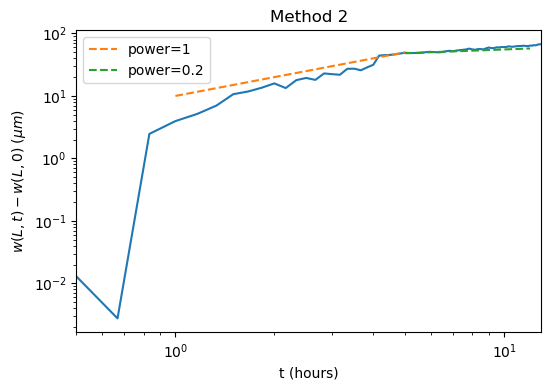

In [22]:
## Plot on log-log scale
t_all = np.arange(t_max)/6; 

h = plt.figure(dpi = 100);
#plt.plot(t_all, widths_all)
plt.plot(t_all, widths_all - widths_all[0])
plt.xlabel('t (hours)')
plt.ylabel('$w(L, t) - w(L, 0)$ ($\mu m$)')
plt.xlim([0.5, 13])
plt.xscale('log')
plt.yscale('log')
plt.title('Method 2')

# Plot power laws
t_sel = np.array([1, 5]);
exp = 1;
c = 10;
plt.plot(t_sel, c*t_sel**exp, '--', label='power='+str(exp))
t_sel2 = np.array([5, 12]);
exp2 = 0.2;
c2 = 35;
plt.plot(t_sel2, c2*t_sel2**exp2, '--', label='power='+str(exp2))

plt.legend();

# Save image
fname_out = folder_figures + im_label + "interface_width_dynamics";
label = '_method_2_log_log';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()